In [209]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

ticker = 'ETH-USD'
days = 14

def load_history(start):
  df = yf.download(ticker, start)
  df["Open_last_day"] = df["Open"].shift(1)
  df = df.dropna()
  df["Open_changes"] = ((df["Open"] / df["Open_last_day"]) -1) * 100
  return df;

def build_train_data(df):
  y_train = []
  x_train = []

  for i in range(0, len(df) - days):
      y_train.append(df["Open_changes"][i])
      x_train.append(np.array(df["Open_changes"][i+1:i+days+1]))

  y_train = np.array(y_train)
  x_train = np.array(x_train).reshape(-1, days, 1)

  return y_train, x_train

In [210]:
# build train data
start = datetime.today() - timedelta(days=365)

df = load_history(start)
print(df)

y_train, x_train = build_train_data(df)

print(y_train[0])
print(x_train[0])

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-03-05  2618.473633  2679.102539  2596.989990  2664.831055  2664.831055   
2022-03-06  2664.943604  2673.637207  2555.037354  2555.037354  2555.037354   
2022-03-07  2555.297607  2639.943115  2455.593750  2497.771240  2497.771240   
2022-03-08  2497.721436  2618.166016  2489.755127  2576.747559  2576.747559   
2022-03-09  2577.165283  2761.796387  2573.655273  2729.783447  2729.783447   
...                 ...          ...          ...          ...          ...   
2023-02-28  1634.502441  1644.435791  1602.428101  1605.895142  1605.895142   
2023-03-01  1606.040405  1663.433716  1601.548584  1663.433716  1663.433716   
2023-03-02  1663.549072  1672.051147  1622.599976  1647.319336  1647.319336   
2023-03-03  1647.557739  1648.475342  1552.451538  1569.167603

<ipython-input-209-549290ef2354>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Open_changes"] = ((df["Open"] / df["Open_last_day"]) -1) * 100


In [211]:
# train model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential()

model.add(LSTM(1, input_shape=(days, 1)))
model.compile(optimizer="rmsprop", loss="mse")

model.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
11/11 [==============================] - 2s 5ms/step - loss: 19.3451
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 19.3426
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 19.3409
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 19.3397
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 19.3379
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 19.3363
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 19.3345
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 19.3329
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 19.3311
Epoch 10/10
11/11 [==============================] - 0s 5ms/step - loss: 19.3293


In [212]:
# use model to get predictions for backtesting
predictions = model.predict(x_train)
predictions = np.append(predictions, np.zeros(days))
df["Predictions"] = predictions
df

11/11 [==============================] - 1s 3ms/step


<ipython-input-212-55cdbe25dd4d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Predictions"] = predictions


,Open,High,Low,Close,Adj Close,Volume,Open_last_day,Open_changes,Predictions
Date,,,,,,,,,
2022-03-05,2618.473633,2679.102539,2596.989990,2664.831055,2664.831055,8072368396,2834.987305,-7.637201,0.004749
2022-03-06,2664.943604,2673.637207,2555.037354,2555.037354,2555.037354,8872976607,2618.473633,1.774697,0.032655
2022-03-07,2555.297607,2639.943115,2455.593750,2497.771240,2497.771240,14594098731,2664.943604,-4.114383,-0.492155
2022-03-08,2497.721436,2618.166016,2489.755127,2576.747559,2576.747559,13922922903,2555.297607,-2.253208,-0.078892
2022-03-09,2577.165283,2761.796387,2573.655273,2729.783447,2729.783447,14173665398,2497.721436,3.180653,0.010366
...,...,...,...,...,...,...,...,...,...
2023-02-28,1634.502441,1644.435791,1602.428101,1605.895142,1605.895142,6323676957,1640.763672,-0.381605,0.000000
2023-03-01,1606.040405,1663.433716,1601.548584,1663.433716,1663.433716,7701847224,1634.502441,-1.741327,0.000000
2023-03-02,1663.549072,1672.051147,1622.599976,1647.319336,1647.319336,7080950926,1606.040405,3.580773,0.000000


In [213]:
# calculate open values from predicted percentage
df["Open_changes_predicted"] = (df["Open_last_day"] / 100 * df["Predictions"]) + df["Open_last_day"]
df

<ipython-input-213-ad7ed03ffa82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Open_changes_predicted"] = (df["Open_last_day"] / 100 * df["Predictions"]) + df["Open_last_day"]


,Open,High,Low,Close,Adj Close,Volume,Open_last_day,Open_changes,Predictions,Open_changes_predicted
Date,,,,,,,,,,
2022-03-05,2618.473633,2679.102539,2596.989990,2664.831055,2664.831055,8072368396,2834.987305,-7.637201,0.004749,2835.121945
2022-03-06,2664.943604,2673.637207,2555.037354,2555.037354,2555.037354,8872976607,2618.473633,1.774697,0.032655,2619.328683
2022-03-07,2555.297607,2639.943115,2455.593750,2497.771240,2497.771240,14594098731,2664.943604,-4.114383,-0.492155,2651.827944
2022-03-08,2497.721436,2618.166016,2489.755127,2576.747559,2576.747559,13922922903,2555.297607,-2.253208,-0.078892,2553.281688
2022-03-09,2577.165283,2761.796387,2573.655273,2729.783447,2729.783447,14173665398,2497.721436,3.180653,0.010366,2497.980350
...,...,...,...,...,...,...,...,...,...,...
2023-02-28,1634.502441,1644.435791,1602.428101,1605.895142,1605.895142,6323676957,1640.763672,-0.381605,0.000000,1640.763672
2023-03-01,1606.040405,1663.433716,1601.548584,1663.433716,1663.433716,7701847224,1634.502441,-1.741327,0.000000,1634.502441
2023-03-02,1663.549072,1672.051147,1622.599976,1647.319336,1647.319336,7080950926,1606.040405,3.580773,0.000000,1606.040405


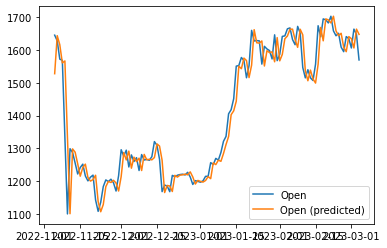

In [214]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.dates import drange

days_to_plot = 120

plt.plot(df.index[-days_to_plot:], df["Open"][-days_to_plot:], label="Open")
plt.plot(df.index[-days_to_plot:], df["Open_changes_predicted"][-days_to_plot:], label="Open (predicted)")

plt.legend()

plt.show()

In [219]:
# predict next day
start = datetime.today() - timedelta(days=days+1)
df_predict = load_history(start)

next_day = df_predict["Open_changes"][-days:]
next_day = np.array(next_day)
next_day = next_day.reshape(-1, days, 1)
pred = model.predict(next_day)
print(pred[0][0])
predict_price = (df_predict["Open"][-1:][0] / 100 * pred[0][0]) + df_predict["Open"][-1:][0]
print(predict_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 21ms/step
-0.7155328
1558.3278875152207


<ipython-input-209-549290ef2354>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Open_changes"] = ((df["Open"] / df["Open_last_day"]) -1) * 100


In [218]:
# retrain model with new data
start = datetime.today() - timedelta(days=60)

df = load_history(start)
y_train, x_train = build_train_data(df)

model.fit(x_train, y_train, batch_size=32, epochs=10)

[*********************100%***********************]  1 of 1 completed
Epoch 1/10
2/2 [==============================] - 0s 8ms/step - loss: 9.8051
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 9.8027
Epoch 3/10
2/2 [==============================] - 0s 8ms/step - loss: 9.7998
Epoch 4/10
2/2 [==============================] - 0s 8ms/step - loss: 9.7971
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 9.7946
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 9.7920
Epoch 7/10
2/2 [==============================] - 0s 8ms/step - loss: 9.7893
Epoch 8/10


<ipython-input-209-549290ef2354>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Open_changes"] = ((df["Open"] / df["Open_last_day"]) -1) * 100


2/2 [==============================] - 0s 8ms/step - loss: 9.7865
Epoch 9/10
2/2 [==============================] - 0s 7ms/step - loss: 9.7835
Epoch 10/10
2/2 [==============================] - 0s 9ms/step - loss: 9.7806
